In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
import os

In [2]:
# Print Tensorflow version
# print(tf.__version__)

# Check available GPU devices.
# print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

def display_image(image):
    # Tạo một hình vẽ (figure) với kích thước 20x15 inch.
    fig = plt.figure(figsize=(20, 15))
    # Tắt lưới lên hình ảnh.
    plt.grid(False)
    # Hiển thị hình ảnh trên hình vẽ.
    plt.imshow(image)
    plt.show()


def download_and_resize_image(url, new_width=256, new_height=256,
                                display=False):
    # Tạo tên tệp tạm thời với đuôi mở rộng ".jpg".
    _, filename = tempfile.mkstemp(suffix=".jpg")
    # Tải hình ảnh từ URL được cung cấp.
    response = urlopen(url)
    return resize_image(response)


def resize_image(url, new_width=256, new_height=256,
                                display=False):
    filename = os.path.basename(url)
    # Mở hình ảnh bằng thư viện PIL.
    pil_image = Image.open(url)
    # Đảm bảo hình ảnh được điều chỉnh kích thước sao cho phù hợp với
    # kích thước mới được chỉ định (new_width, new_height) bằng phương thức
    # ImageOps.fit() sử dụng thuật toán LANCZOS.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    # Chuyển đổi hình ảnh sang chế độ RGB.
    pil_image_rgb = pil_image.convert("RGB")
    # Lưu hình ảnh xuống tệp với định dạng JPEG và chất lượng ảnh 90%.
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    # In thông báo về việc tải hình ảnh xuống tệp.
    print("Image downloaded to %s." % filename)
    # Nếu có yêu cầu hiển thị hình ảnh, thì gọi hàm display_image().
    if display:
        display_image(pil_image)
    # Trả về tên tệp của hình ảnh tải về.
    return filename

In [3]:
def draw_bounding_box_on_image(image,
                                ymin,
                                xmin,
                                ymax,
                                xmax,
                                color,
                                font,
                                thickness=4,
                                display_str_list=()):
    """Thêm một hộp giới hạn vào hình ảnh."""
    # Tạo đối tượng vẽ hình trên hình ảnh sử dụng thư viện PIL.
    draw = ImageDraw.Draw(image)
    # Lấy chiều rộng và chiều cao của hình ảnh.
    im_width, im_height = image.size
    # Tính toán tọa độ của các đỉnh của hộp giới hạn trên hình ảnh.
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                    ymin * im_height, ymax * im_height)
    # Vẽ các đường kết nối các đỉnh để tạo hình chữ nhật.
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                (left, top)],
                width=thickness,
                fill=color)

    # Kiểm tra xem tổng chiều cao của các chuỗi hiển thị được thêm vào
    # ở phía trên hộp giới hạn có vượt quá phía trên của hình ảnh hay không.
    display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
    # Mỗi chuỗi hiển thị có lề phía trên và phía dưới là 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Đảo ngược danh sách chuỗi hiển thị và in chúng từ dưới lên trên.
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]
        margin = np.ceil(0.05 * text_height)
        # Vẽ hình chữ nhật nền cho chuỗi hiển thị.
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                    fill=color)
        # In chuỗi hiển thị lên hình ảnh.
        draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Chồng chất các hộp được ghi nhãn lên một hình ảnh với điểm số định dạng và tên nhãn."""

    # Lấy danh sách các màu sắc có sẵn trong PIL.
    colors = list(ImageColor.colormap.values())

    try:
        # Cố gắng tải phông chữ từ đường dẫn cụ thể.
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                25)
    except IOError:
        # Nếu không tìm thấy phông chữ, sử dụng phông mặc định và in thông báo lỗi.
        print("Không tìm thấy phông chữ, sử dụng phông mặc định.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        # Kiểm tra xem điểm số của hộp vượt qua ngưỡng tối thiểu không.
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            # Tạo chuỗi hiển thị với tên lớp và điểm số định dạng.
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                            int(100 * scores[i]))
            # Chọn màu sắc dựa trên tên lớp.
            color = colors[hash(class_names[i]) % len(colors)]
            # Chuyển đổi hình ảnh thành định dạng PIL RGB.
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            # Vẽ hộp giới hạn lên hình ảnh.
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            # Sao chép hình ảnh PIL đã được chỉnh sửa trở lại hình ảnh gốc.
            np.copyto(image, np.array(image_pil))
    
    # Trả về hình ảnh gốc đã được chỉnh sửa.
    return image

In [4]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
def load_img(path):
    # Đọc nội dung tệp ảnh tại đường dẫn đã cho.
    img = tf.io.read_file(path)
    # Giải mã nội dung tệp ảnh dưới định dạng JPEG với 3 kênh màu.
    img = tf.image.decode_jpeg(img, channels=3)
    # Trả về hình ảnh đã giải mã.
    return img

def run_detector(detector, path):
    # Sử dụng hàm load_img() để tải và giải mã hình ảnh từ tệp tại đường dẫn đã cho.
    img = load_img(path)
    
    # Chuyển đổi hình ảnh thành định dạng dấu phẩy động (float32) và thêm chiều batch (tf.newaxis).
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # Ghi lại thời gian bắt đầu để đo thời gian thực hiện việc dự đoán.
    start_time = time.time()
    
    # Sử dụng mô hình "detector" để dự đoán trên hình ảnh đã chuyển đổi.
    result = detector(converted_img)
    
    # Ghi lại thời gian kết thúc sau khi dự đoán hoàn thành.
    end_time = time.time()

    # Chuyển đổi kết quả từ các tensor sang NumPy arrays để dễ xử lý.
    result = {key:value.numpy() for key,value in result.items()}

    # In ra số lượng đối tượng được tìm thấy trong hình ảnh.
    print("Found %d objects." % len(result["detection_scores"]))
    
    # In ra thời gian dự đoán (inference time) được tính toán.
    print("Inference time: ", end_time-start_time)

    # Gọi hàm draw_boxes() để vẽ hộp giới hạn và thông tin lớp lên hình ảnh.
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    # Gọi hàm display_image() để hiển thị hình ảnh với các hộp giới hạn.
    display_image(image_with_boxes)

Image downloaded to British_Longhair (2).jpg.


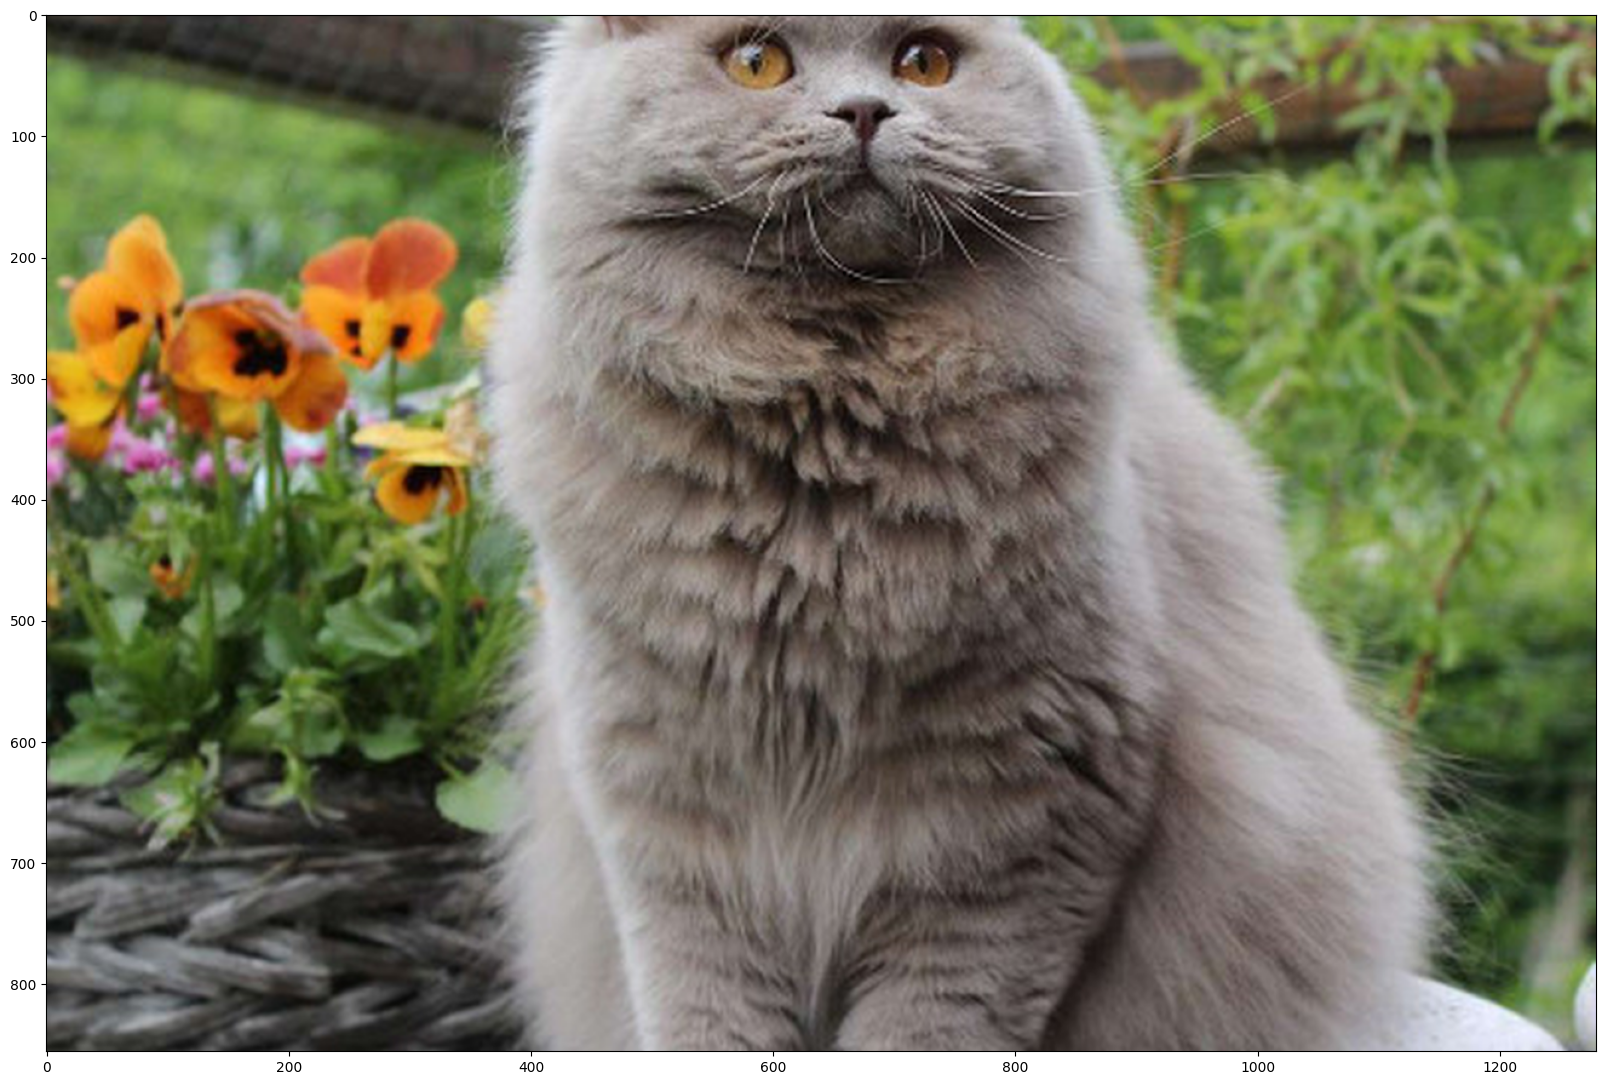

In [6]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "C:\\Users\\ngod2\\thigiacMayTinh\\cats_photos\\British_Longhair\\British_Longhair (2).jpg" 
# downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

downloaded_image_path = resize_image(image_url, 1280, 856, True)

Found 100 objects.
Inference time:  76.80050253868103
Không tìm thấy phông chữ, sử dụng phông mặc định.


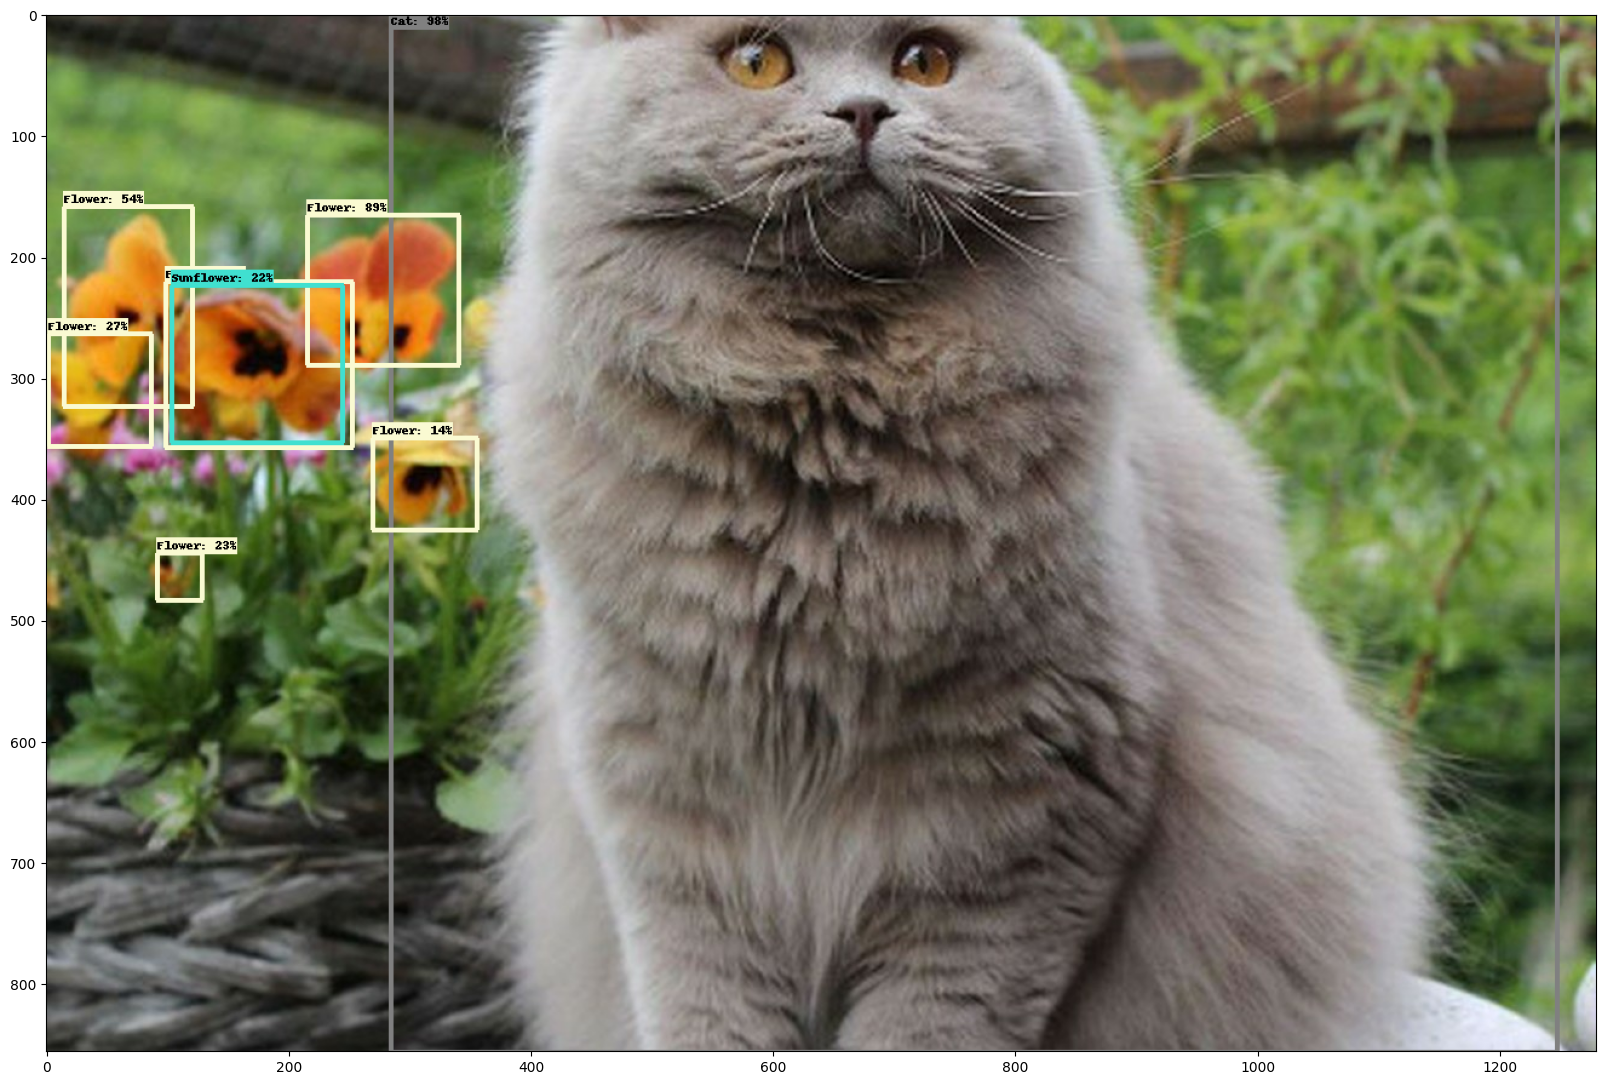

In [7]:
run_detector(detector, downloaded_image_path)